## Introduction To Keras

Keras Applications are deep learning models that are made available alongside pre-trained weights. These models can be used for prediction, feature extraction, and fine-tuning.Weights are downloaded automatically when instantiating a model. They are stored at ~/.keras/models/.

## Transfer Learning and Fine Tuning
Transfer Learning use a pre-trained Neural Network.It divert the output of the orginal model before 
its classification layers.Classification layer is optimized leaving the 
original weight untouched.In Fine tuning the weights which were frozen 
are optimized to the new dataset.The weights of new classification,some or all layers are optmized.

In [ ]:
![Chart of Pre-trained Networks](images/documentation.png)

## Imports

In [1]:
import os
import PIL
import numpy as np
%matplotlib inline
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.models import load_model
from keras.applications import Xception
from keras.layers import Input,Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers import Activation, Dense
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.core import Dropout, Activation
from keras.layers import Dense, Activation, Flatten
from keras.layers.pooling import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.applications.xception import preprocess_input, decode_predictions

Using TensorFlow backend.


In [2]:
tf.__version__

'1.12.0'

## Helper Functions

### Helper-function for joining a directory and list of filenames.

In [3]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

### Helper-function for plotting images

Function used to plot at most 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [4]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for printing confusion matrix

In [5]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

### Helper-function for plotting example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [6]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

Function for calculating the predicted classes of the entire test-set and calling the above function to plot a few examples of mis-classified images.

In [7]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

### Helper-function for loading images

The data-set is not loaded into memory, instead it has a list of the files for the images in the training-set and another list of the files for the images in the test-set. This helper-function loads some image-files.

In [8]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

### Helper-function for plotting training history

This plots the classification accuracy and loss-values recorded during training with the Keras API.

In [9]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

## Pre-Trained Model: Xception

The Xception model contains a convolutional part and a fully-connected (or dense) part which is used for classification. If `include_top=True` then the whole Xception model is downloaded which is about 528 MB. If `include_top=False` then only the convolutional part of the Xception model is downloaded which is just 57 MB. We will Xception on our new dataset Mitero

In [2]:
model = Xception(include_top=True, weights='imagenet',input_tensor=None, input_shape=(299, 299, 3), pooling=None, classes=1000)

## Input Pipeline

The Keras API has its own way of creating the input pipeline for training a model using files.

First we need to know the shape of the tensors expected as input by the pre-trained Xception model. In this case it is images of shape 224 x 224 x 3.

In [3]:
input_shape = model.layers[0].output_shape[1:3]
input_shape

(299, 299)

Keras uses a so-called data-generator for inputting data into the neural network, which will loop over the data for eternity.

We have a small training-set so it helps to artificially inflate its size by making various transformations to the images. We use a built-in data-generator that can make these random transformations. This is also called an augmented dataset.

In [12]:
datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=180,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

We also need a data-generator for the test-set, but this should not do any transformations to the images because we want to know the exact classification accuracy on those specific images. So we just rescale the pixel-values so they are between 0.0 and 1.0 because this is expected by the Xception model.

In [13]:
datagen_test = ImageDataGenerator(rescale=1./255)

The data-generators will return batches of images. 

In [14]:
batch_size = 20

We can save the randomly transformed images during training, so as to inspect whether they have been overly distorted, so we have to adjust the parameters for the data-generator above.

In [15]:
if True:
    save_to_dir = None
else:
    save_to_dir='augmented_images/'

Now we create the actual data-generator that will read files from disk, resize the images and return a random batch.

It is somewhat awkward that the construction of the data-generator is split into these two steps, but it is probably because there are different kinds of data-generators available for different data-types (images, text, etc.) and sources (memory or disk).

In [16]:
base_dir = '/home/rutherford/Github/Audilab_Project/11.Tree_Species_Indetification/data/Mutero_Images/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')

In [17]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir)

Found 38777 images belonging to 143 classes.


The data-generator for the test-set should not transform and shuffle the images.

In [18]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 5157 images belonging to 143 classes.


Because the data-generators will loop for eternity, we need to specify the number of steps to perform during evaluation and prediction on the test-set. Because our test-set contains 530 images and the batch-size is set to 20, the number of steps is 26.5 for one full processing of the test-set. This is why we need to reset the data-generator's counter in the `example_errors()` function above, so it always starts processing from the beginning of the test-set.

This is another slightly awkward aspect of the Keras API which could perhaps be improved.

In [19]:
steps_test = generator_test.n / batch_size
steps_test

257.85

Get the file-paths for all the images in the training- and test-sets.

In [20]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

Get the class-numbers for all the images in the training- and test-sets.

In [21]:
cls_train = generator_train.classes
cls_test = generator_test.classes

Get the class-names for the dataset.

In [22]:
class_names = list(generator_train.class_indices.keys())
class_names

['Acacia_abyssinica',
 'Acacia_kirkii',
 'Acacia_mearnsii',
 'Acacia_melanoxylon',
 'Acacia_nilotica',
 'Acacia_polyacantha',
 'Acacia_senegal',
 'Acacia_seyal',
 'Acacia_xanthophloea',
 'Afrocarpus_falcatus',
 'Afzelia_quanzensis',
 'Albizia_gummifera',
 'Albizia_lebbeck',
 'Allanblackia_floribunda',
 'Artocarpus_heterophyllus',
 'Azadirachta_indica',
 'Balanites_aegyptiaca',
 'Bersama_abyssinica',
 'Bischofia_javanica',
 'Brachylaena_huillensis',
 'Bridelia_micrantha',
 'Calodendron_capensis',
 'Calodendrum_capense',
 'Casimiroa_edulis',
 'Cassipourea_malosana',
 'Casuarina_cunninghamiana',
 'Casuarina_equisetifolia',
 'Catha_edulis',
 'Cathium_Keniensis',
 'Ceiba_pentandra',
 'Celtis_africana',
 'Chionanthus_battiscombei',
 'Clausena_anisat',
 'Clerodendrum_johnstonii',
 'Combretum_molle',
 'Cordia_africana',
 'Cordia_africana_Cordia',
 'Cotoneaster_Pannos',
 'Croton_macrostachyus',
 'Croton_megalocarpus',
 'Cupressus_lusitanica',
 'Cussonia_Spicata',
 'Cussonia_holstii',
 'Diospyro

Get the number of classes for the dataset.

In [23]:
num_classes = generator_train.num_classes
num_classes

143

In [24]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels #class_mode='softmax'
        )

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20, #class_mode='softmax'
        )

Found 38777 images belonging to 143 classes.
Found 3571 images belonging to 143 classes.


In [25]:
classes = train_generator.class_indices
print(classes)

{'Acacia_abyssinica': 0, 'Acacia_kirkii': 1, 'Acacia_mearnsii': 2, 'Acacia_melanoxylon': 3, 'Acacia_nilotica': 4, 'Acacia_polyacantha': 5, 'Acacia_senegal': 6, 'Acacia_seyal': 7, 'Acacia_xanthophloea': 8, 'Afrocarpus_falcatus': 9, 'Afzelia_quanzensis': 10, 'Albizia_gummifera': 11, 'Albizia_lebbeck': 12, 'Allanblackia_floribunda': 13, 'Artocarpus_heterophyllus': 14, 'Azadirachta_indica': 15, 'Balanites_aegyptiaca': 16, 'Bersama_abyssinica': 17, 'Bischofia_javanica': 18, 'Brachylaena_huillensis': 19, 'Bridelia_micrantha': 20, 'Calodendron_capensis': 21, 'Calodendrum_capense': 22, 'Casimiroa_edulis': 23, 'Cassipourea_malosana': 24, 'Casuarina_cunninghamiana': 25, 'Casuarina_equisetifolia': 26, 'Catha_edulis': 27, 'Cathium_Keniensis': 28, 'Ceiba_pentandra': 29, 'Celtis_africana': 30, 'Chionanthus_battiscombei': 31, 'Clausena_anisat': 32, 'Clerodendrum_johnstonii': 33, 'Combretum_molle': 34, 'Cordia_africana': 35, 'Cordia_africana_Cordia': 36, 'Cotoneaster_Pannos': 37, 'Croton_macrostachyus

### Plot a few images to see if data is correct

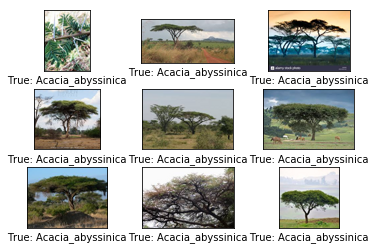

In [26]:
# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[0:9])

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

### Class Weights

The Knifey-Spoony dataset is quite imbalanced because it has few images of forks, more images of knives, and many more images of spoons. This can cause a problem during training because the neural network will be shown many more examples of spoons than forks, so it might become better at recognizing spoons.

Here we use scikit-learn to calculate weights that will properly balance the dataset. These weights are applied to the gradient for each image in the batch during training, so as to scale their influence on the overall gradient for the batch.

In [27]:
from sklearn.utils.class_weight import compute_class_weight

In [28]:
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

Note how the weight is about 1.398 for the forky-class and only 0.707 for the spoony-class. This is because there are fewer images for the forky-class so the gradient should be amplified for those images, while the gradient should be lowered for spoony-images.

In [29]:
class_weight

array([0.92233957, 1.16882686, 0.88328284, 0.66626003, 0.67287303,
       0.77476523, 1.06340326, 0.86912767, 0.72119104, 0.6410587 ,
       0.98606484, 1.02715088, 0.63954677, 1.54953047, 0.60259518,
       0.75745205, 1.19457195, 1.21057068, 0.70616623, 1.64344141,
       0.85541903, 0.55910893, 0.74292557, 0.57941844, 1.41233246,
       1.70545806, 0.54560932, 0.93506149, 2.48777828, 0.54342251,
       0.66626003, 4.10860352, 2.05430176, 0.67287303, 0.77255793,
       1.14901624, 1.05512775, 1.26124573, 1.72718364, 2.11849869,
       0.74908241, 0.62625365, 5.76952834, 1.06758989, 1.67387551,
       3.30692478, 2.607383  , 0.62481067, 1.39060427, 1.36265242,
       2.31767378, 1.76083008, 0.91610754, 1.66360633, 1.25540663,
       0.51067388, 0.75957376, 3.30692478, 0.64410411, 1.10230826,
       1.03895721, 1.40501467, 1.13936064, 2.05430176, 0.56493298,
       1.39777233, 0.76170739, 3.30692478, 0.61489304, 0.8500559 ,
       0.66462704, 0.48859069, 0.52756388, 1.38350935, 0.52551

In [30]:
class_names

['Acacia_abyssinica',
 'Acacia_kirkii',
 'Acacia_mearnsii',
 'Acacia_melanoxylon',
 'Acacia_nilotica',
 'Acacia_polyacantha',
 'Acacia_senegal',
 'Acacia_seyal',
 'Acacia_xanthophloea',
 'Afrocarpus_falcatus',
 'Afzelia_quanzensis',
 'Albizia_gummifera',
 'Albizia_lebbeck',
 'Allanblackia_floribunda',
 'Artocarpus_heterophyllus',
 'Azadirachta_indica',
 'Balanites_aegyptiaca',
 'Bersama_abyssinica',
 'Bischofia_javanica',
 'Brachylaena_huillensis',
 'Bridelia_micrantha',
 'Calodendron_capensis',
 'Calodendrum_capense',
 'Casimiroa_edulis',
 'Cassipourea_malosana',
 'Casuarina_cunninghamiana',
 'Casuarina_equisetifolia',
 'Catha_edulis',
 'Cathium_Keniensis',
 'Ceiba_pentandra',
 'Celtis_africana',
 'Chionanthus_battiscombei',
 'Clausena_anisat',
 'Clerodendrum_johnstonii',
 'Combretum_molle',
 'Cordia_africana',
 'Cordia_africana_Cordia',
 'Cotoneaster_Pannos',
 'Croton_macrostachyus',
 'Croton_megalocarpus',
 'Cupressus_lusitanica',
 'Cussonia_Spicata',
 'Cussonia_holstii',
 'Diospyro

## Example Predictions

Here we will show a few examples of using the pre-trained Xception model for prediction.

We need a helper-function for loading and resizing an image so it can be input to the Xception model, as well as doing the actual prediction and showing the result.

In [17]:
def predict(image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    input_shape = (299, 299)
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # Use the Xception model to make a prediction.
    # This outputs an array with 1000 numbers corresponding to
    # the classes of the ImageNet-dataset.
    pred = model.predict(img_array)
    
    # Decode the output of the Xception model.
    pred_decoded = decode_predictions(pred)[0]

    # Print the predictions.
    for code, name, score in pred_decoded:
        print("{0:>3%} : {1}".format(score, name))
        



We can then use the Xception model on a picture of a tree to classify it.

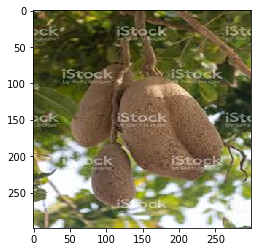

99.986720% : ping-pong_ball
0.011638% : web_site
0.001098% : tripod
0.000398% : military_uniform
0.000087% : mixing_bowl


In [18]:
predict(image_path='images/kikuyes.jpeg')

In [33]:
def predict(image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    input_shape = (299, 299)
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # Use the Xception model to make a prediction.
    # This outputs an array with 1000 numbers corresponding to
    # the classes of the ImageNet-dataset.
    pred = model.predict(img_array)
    
    # Decode the output of the Xception model.
    pred_decoded = decode_predictions(pred)[0]

    # Print the predictions.
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

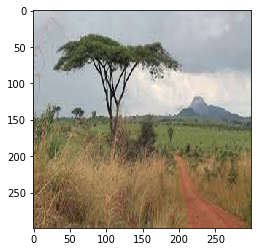

100.00% : safety_pin
 0.00% : mixing_bowl
 0.00% : sea_urchin
 0.00% : rubber_eraser
 0.00% : black-footed_ferret


In [34]:
predict(image_path=image_paths_train[1])

We can also try an image from our new test-set, and again the Xception model is very confused.

In [35]:
classes

{'Acacia_abyssinica': 0,
 'Acacia_kirkii': 1,
 'Acacia_mearnsii': 2,
 'Acacia_melanoxylon': 3,
 'Acacia_nilotica': 4,
 'Acacia_polyacantha': 5,
 'Acacia_senegal': 6,
 'Acacia_seyal': 7,
 'Acacia_xanthophloea': 8,
 'Afrocarpus_falcatus': 9,
 'Afzelia_quanzensis': 10,
 'Albizia_gummifera': 11,
 'Albizia_lebbeck': 12,
 'Allanblackia_floribunda': 13,
 'Artocarpus_heterophyllus': 14,
 'Azadirachta_indica': 15,
 'Balanites_aegyptiaca': 16,
 'Bersama_abyssinica': 17,
 'Bischofia_javanica': 18,
 'Brachylaena_huillensis': 19,
 'Bridelia_micrantha': 20,
 'Calodendron_capensis': 21,
 'Calodendrum_capense': 22,
 'Casimiroa_edulis': 23,
 'Cassipourea_malosana': 24,
 'Casuarina_cunninghamiana': 25,
 'Casuarina_equisetifolia': 26,
 'Catha_edulis': 27,
 'Cathium_Keniensis': 28,
 'Ceiba_pentandra': 29,
 'Celtis_africana': 30,
 'Chionanthus_battiscombei': 31,
 'Clausena_anisat': 32,
 'Clerodendrum_johnstonii': 33,
 'Combretum_molle': 34,
 'Cordia_africana': 35,
 'Cordia_africana_Cordia': 36,
 'Cotoneast

## Transfer Learning

The pre-trained Xception model was unable to classify images from the mutero dataset. The reason is perhaps that the Xception model was trained on the so-called ImageNet dataset which may not have contained many images of Tress.

The lower layers of a Convolutional Neural Network can recognize many different shapes or features in an image. It is the last few fully-connected layers that combine these featuers into classification of a whole image. So we can try and re-route the output of the last convolutional layer of the Xception model to a new fully-connected neural network that we create for doing classification on the Mitero dataset.

First we print a summary of the Xception model so we can see the names and types of its layers, as well as the shapes of the tensors flowing between the layers. This is one of the major reasons we are using the Xception model in this tutorial, because the Inception v3 model has so many layers that it is confusing when printed out.

In [36]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

We can see that the last convolutional layer is called 'block5_pool' so we use Keras to get a reference to that layer.

In [37]:
transfer_layer = model.get_layer('block14_sepconv2_act')

We refer to this layer as the Transfer Layer because its output will be re-routed to our new fully-connected neural network which will do the classification for the Knifey-Spoony dataset.

The output of the transfer layer has the following shape:

In [38]:
transfer_layer.output

<tf.Tensor 'block14_sepconv2_act/Relu:0' shape=(?, 10, 10, 2048) dtype=float32>

Using the Keras API it is very simple to create a new model. First we take the part of the Xception model from its input-layer to the output of the transfer-layer. We may call this the convolutional model, because it consists of all the convolutional layers from the Xception model.

In [39]:
input_shape=(299, 299, 3)

In [40]:
conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

We can then use Keras to build a new model on top of this.

In [41]:
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the Xception model from above.
new_model.add(conv_model)

# Flatten the output of the Xception model because it is from a
# convolutional layer.
new_model.add(Flatten(input_shape = ( 299, 299)))  

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the Xception model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add the final layer for the actual classification.
new_model.add(Dense(num_classes, activation='softmax'))

We use the Adam optimizer with a fairly low learning-rate. The learning-rate could perhaps be larger. But if you try and train more layers of the original Xception model, then the learning-rate should be quite low otherwise the pre-trained weights of the Xception model will be distorted and it will be unable to learn.

In [42]:
optimizer = Adam(lr=1e-5)

We have 3 classes in the Knifey-Spoony dataset so Keras needs to use this loss-function.

In [43]:
loss = 'categorical_crossentropy'

The only performance metric we are interested in is the classification accuracy.

In [44]:
metrics = ['categorical_accuracy']

Helper-function for printing whether a layer in the Xception model should be trained.

In [45]:
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

By default all the layers of the Xception model are trainable.

In [46]:
print_layer_trainable()

False:	input_1
True:	block1_conv1
True:	block1_conv1_bn
True:	block1_conv1_act
True:	block1_conv2
True:	block1_conv2_bn
True:	block1_conv2_act
True:	block2_sepconv1
True:	block2_sepconv1_bn
True:	block2_sepconv2_act
True:	block2_sepconv2
True:	block2_sepconv2_bn
True:	conv2d_1
True:	block2_pool
True:	batch_normalization_1
True:	add_1
True:	block3_sepconv1_act
True:	block3_sepconv1
True:	block3_sepconv1_bn
True:	block3_sepconv2_act
True:	block3_sepconv2
True:	block3_sepconv2_bn
True:	conv2d_2
True:	block3_pool
True:	batch_normalization_2
True:	add_2
True:	block4_sepconv1_act
True:	block4_sepconv1
True:	block4_sepconv1_bn
True:	block4_sepconv2_act
True:	block4_sepconv2
True:	block4_sepconv2_bn
True:	conv2d_3
True:	block4_pool
True:	batch_normalization_3
True:	add_3
True:	block5_sepconv1_act
True:	block5_sepconv1
True:	block5_sepconv1_bn
True:	block5_sepconv2_act
True:	block5_sepconv2
True:	block5_sepconv2_bn
True:	block5_sepconv3_act
True:	block5_sepconv3
True:	block5_sepconv3_bn
True:	a

In Transfer Learning we are initially only interested in reusing the pre-trained Xception model as it is, so we will disable training for all its layers.

In [47]:
conv_model.trainable = False

In [48]:
for layer in conv_model.layers:
    layer.trainable = False

In [49]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv1_bn
False:	block1_conv1_act
False:	block1_conv2
False:	block1_conv2_bn
False:	block1_conv2_act
False:	block2_sepconv1
False:	block2_sepconv1_bn
False:	block2_sepconv2_act
False:	block2_sepconv2
False:	block2_sepconv2_bn
False:	conv2d_1
False:	block2_pool
False:	batch_normalization_1
False:	add_1
False:	block3_sepconv1_act
False:	block3_sepconv1
False:	block3_sepconv1_bn
False:	block3_sepconv2_act
False:	block3_sepconv2
False:	block3_sepconv2_bn
False:	conv2d_2
False:	block3_pool
False:	batch_normalization_2
False:	add_2
False:	block4_sepconv1_act
False:	block4_sepconv1
False:	block4_sepconv1_bn
False:	block4_sepconv2_act
False:	block4_sepconv2
False:	block4_sepconv2_bn
False:	conv2d_3
False:	block4_pool
False:	batch_normalization_3
False:	add_3
False:	block5_sepconv1_act
False:	block5_sepconv1
False:	block5_sepconv1_bn
False:	block5_sepconv2_act
False:	block5_sepconv2
False:	block5_sepconv2_bn
False:	block5_sepconv3_act
False:	block

Once we have changed whether the model's layers are trainable, we need to compile the model for the changes to take effect.

In [50]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

An epoch normally means one full processing of the training-set. But the data-generator that we created above, will produce batches of training-data for eternity. So we need to define the number of steps we want to run for each "epoch" and this number gets multiplied by the batch-size defined above. In this case we have 100 steps per epoch and a batch-size of 20, so the "epoch" consists of 2000 random images from the training-set. We run 20 such "epochs".

The reason these particular numbers were chosen, was because they seemed to be sufficient for training with this particular model and dataset, and it didn't take too much time, and resulted in 20 data-points (one for each "epoch") which can be plotted afterwards.

In [51]:
epochs = 50
steps_per_epoch = 100

Training the new model is just a single function call in the Keras API. This takes about 6-7 minutes on a GTX 1070 GPU.

In [52]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Epoch 1/50


ResourceExhaustedError: OOM when allocating tensor with shape[20,147,147,64] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node model_1/block1_conv2/convolution}} = Conv2D[T=DT_FLOAT, _class=["loc:@model_1/block1_conv2_bn/cond/FusedBatchNorm/Switch"], data_format="NHWC", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](model_1/block1_conv1_act/Relu, block1_conv2/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Keras records the performance metrics at the end of each "epoch" so they can be plotted later. This shows that the loss-value for the training-set generally decreased during training, but the loss-values for the test-set were a bit more erratic. Similarly, the classification accuracy generally improved on the training-set while it was a bit more erratic on the test-set.

In [1]:
plot_training_history(history)

NameError: name 'plot_training_history' is not defined

After training we can also evaluate the new model's performance on the test-set using a single function call in the Keras API.

In [2]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

NameError: name 'new_model' is not defined

In [3]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

NameError: name 'result' is not defined

We can plot some examples of mis-classified images from the test-set. Some of these images are also difficult for a human to classify.

The confusion matrix shows that the new model is especially having problems classifying the forky-class.

In [4]:
example_errors()

NameError: name 'example_errors' is not defined

## Fine-Tuning

In Transfer Learning the original pre-trained model is locked or frozen during training of the new classifier. This ensures that the weights of the original Xception model will not change. One advantage of this, is that the training of the new classifier will not propagate large gradients back through the Xception model that may either distort its weights or cause overfitting to the new dataset.

But once the new classifier has been trained we can try and gently fine-tune some of the deeper layers in the Xception model as well. We call this Fine-Tuning.

It is a bit unclear whether Keras uses the `trainable` boolean in each layer of the original Xception model or if it is overrided by the `trainable` boolean in the "meta-layer" we call `conv_layer`. So we will enable the `trainable` boolean for both `conv_layer` and all the relevant layers in the original Xception model.

In [5]:
conv_model.trainable = True

NameError: name 'conv_model' is not defined

We want to train the last two convolutional layers whose names contain 'block5' or 'block4'.

In [6]:
for layer in conv_model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable

NameError: name 'conv_model' is not defined

We can check that this has updated the `trainable` boolean for the relevant layers.

In [60]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


We will use a lower learning-rate for the fine-tuning so the weights of the original Xception model only get changed slowly.

In [61]:
optimizer_fine = Adam(lr=1e-7)

Because we have defined a new optimizer and have changed the `trainable` boolean for many of the layers in the model, we need to recompile the model so the changes can take effect before we continue training.

In [62]:
new_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)

The training can then be continued so as to fine-tune the Xception model along with the new classifier.

In [63]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Epoch 1/20
100/100 [==============================] - 27s 273ms/step - loss: 0.4715 - categorical_accuracy: 0.8105 - val_loss: 0.5107 - val_categorical_accuracy: 0.7717
Epoch 2/20
100/100 [==============================] - 24s 241ms/step - loss: 0.4656 - categorical_accuracy: 0.8067 - val_loss: 0.5141 - val_categorical_accuracy: 0.7717
Epoch 3/20
100/100 [==============================] - 25s 252ms/step - loss: 0.4359 - categorical_accuracy: 0.8210 - val_loss: 0.5059 - val_categorical_accuracy: 0.7717
Epoch 4/20
100/100 [==============================] - 24s 237ms/step - loss: 0.4324 - categorical_accuracy: 0.8355 - val_loss: 0.5057 - val_categorical_accuracy: 0.7736
Epoch 5/20
100/100 [==============================] - 25s 248ms/step - loss: 0.4243 - categorical_accuracy: 0.8340 - val_loss: 0.4981 - val_categorical_accuracy: 0.7792
Epoch 6/20
100/100 [==============================] - 24s 241ms/step - loss: 0.4224 - categorical_accuracy: 0.8395 - val_loss: 0.5045 - val_categorical_acc

We can then plot the loss-values and classification accuracy from the training. Depending on the dataset, the original model, the new classifier, and hyper-parameters such as the learning-rate, this may improve the classification accuracies on both training- and test-set, or it may improve on the training-set but worsen it for the test-set in case of overfitting. It may require some experimentation with the parameters to get this right.

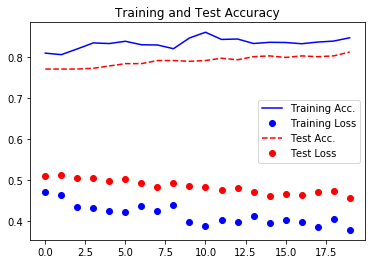

In [64]:
plot_training_history(history)

In [65]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

In [66]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 81.32%


We can plot some examples of mis-classified images again, and we can also see from the confusion matrix that the model is still having problems classifying forks correctly.

A part of the reason might be that the training-set contains only 994 images of forks, while it contains 1210 images of knives and 1966 images of spoons. Even though we have weighted the classes to compensate for this imbalance, and we have also augmented the training-set by randomly transforming the images in different ways during training, it may not be enough for the model to properly learn to recognize forks.

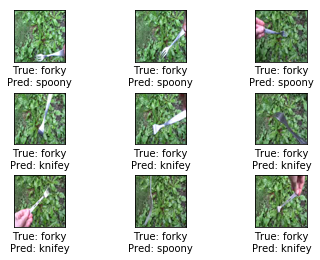

Confusion matrix:
[[138   6   7]
 [ 40  95   2]
 [ 33  11 198]]
(0) forky
(1) knifey
(2) spoony


In [67]:
example_errors()

## Prediction Using The Model

In [ ]:
from keras.preprocessing.image import img_to_array,load_img
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
def pred(img_path):    
    img = load_img(img_path,target_size = (299,299)) #Load the image and set the target size to the size of input of our model
    x = img_to_array(img) #Convert the image to array
    x = np.expand_dims(x,axis=0) #Convert the array to the form (1,x,y,z) 
    x = preprocess_input(x) # Use the preprocess input function o subtract the mean of all the images
    p = np.argmax(model.predict(x)) # Store the argmax of the predictions
    if p==0:     # P=0 for basal,P=1 for melanoma , P=2 for squamous
        print("Acacia_abyssinica")
    elif p==1:
        print("Acacia_kirkii")
    elif p==2:
        print("Acacia_mearnsii")
    elif p==3:
        print("Acacia_melanoxylon")   
    elif p==4:
        print("Acacia_nilotica")
    elif p==5:
        print("Acacia_polyacantha")      
    elif p==6:
        print("Acacia_senegal")      
    elif p==7:
        print("Acacia_seyal")
    elif p==8:
        print("Acacia_xanthophloea")        
    elif p==9:
        print("Afrocarpus_falcatus")
    elif p==10:
        print("Afzelia_quanzensis")        
    elif p==11:
        print("Albizia_gummifera")
    elif p==12:
        print("Albizia_lebbeck")       
    elif p==13:
        print("Allanblackia_floribunda")
    elif p==14:
        print("Artocarpus_heterophyllus")        
    elif p==15:
        print("Azadirachta_indica")
    elif p==16:
        print("Balanites_aegyptiaca")        
    elif p==17:
        print("Bersama_abyssinica")
    elif p==18:
        print("Bischofia_javanica")        
    elif p==19:
        print("Brachylaena_huillensis")
    elif p==20:
        print("Bridelia_micrantha")        
    elif p==21:
        print("Calodendron_capensis")
    elif p==22:
        print("Calodendrum_capense")        
    elif p==23:
        print("Casimiroa_edulis")
    elif p==24:
        print("Cassipourea_malosana")        
    elif p==25:
        print("Casuarina_cunninghamiana")
    elif p==26:
        print("Casuarina_equisetifolia")
    elif p==27:
        print("Catha_edulis")
    elif p==28:
        print("Cathium_Keniensis")  
    elif p==29:
        print("Ceiba_pentandra")
    elif p==30:
        print("Celtis_africana")
    elif p==31:
        print("Chionanthus_battiscombei")        
    elif p==32:
        print("Clausena_anisat")
    elif p==33:
        print("Clerodendrum_johnstonii")        
    elif p==34:
        print("Combretum_molle")
    elif p==35:
        print("Cordia_africana")        
    elif p==36:
        print("Cordia_africana_Cordia")
    elif p==37:
        print("Cotoneaster_Pannos")        
    elif p==38:
        print("Croton_macrostachyus")
    elif p==39:
        print("Croton_megalocarpus")
    elif p==40:
        print("Cupressus_lusitanica")
    elif p==41:
        print("Cussonia_Spicata")        
    elif p==42:
        print("Cussonia_holstii")
    elif p==43:
        print("Diospyros_abyssinica")        
    elif p==44:
        print("Dodonaea_angustifolia")
    elif p==45:
        print("Dodonaea_viscosa")        
    elif p==46:
        print("Dombeya_goetzenii")
    elif p==47:
        print("Dombeya_rotundifolia")        
    elif p==48:
        print("Dombeya_torrida")
    elif p==49:
        print("Dovyalis_abyssinica")        
    elif p==50:
        print("Dovyalis_macrocalyx")
    elif p==51:
        print("Drypetes_gerrardii")        
    elif p==52:
        print("Ehretia_cymosa")
    elif p==53:
        print("Ekeber_Capensis")        
    elif p==54:
        print("Erica_arborea")
    elif p==55:
        print("Eriobotrya_japonica")        
    elif p==56:
        print("Erythrina_abyssinica")
    elif p==57:
        print("Eucalyptus_camaldulensis")        
    elif p==58:
        print("Eucalyptus_globulus")
    elif p==59:
        print("Eucalyptus_grandis")        
    elif p==60:
        print("Eucalyptus_grandis_saligna")
    elif p==61:
        print("Eucalyptus_hybrids")        
    elif p==62:
        print("Eucalyptus_saligna")
    elif p==63:
        print("Euclea_divinorum")        
    elif p==64:
        print("Ficus_indica")
    elif p==65:
        print("Ficus_natalensi")        
    elif p==66:
        print("Ficus_sur")
    elif p==67:
        print("Ficus_sycomorus")    
    elif p==68:
        print("Ficus_thonningii")        
    elif p==69:
        print("Flacourtia_indica")
    elif p==70:
        print("Flacourtiaceae")        
    elif p==71:
        print("Fraxinus_pennsylvanica")
    elif p==72:
        print("Grevillea_robusta")        
    elif p==73:
        print("Hagenia_abyssinica")
    elif p==74:
        print("Jacaranda_mimosifolia")        
    elif p==75:
        print("Juniperus_procera")
    elif p==76:
        print("Kigelia_africana")        
    elif p==77:
        print("Macaranga_capensis")
    elif p==78:
        print("Mangifera_indica'")
    elif p==79:
        print("Manilkara_Discolor")        
    elif p==80:
        print("Markhamia_lutea")
    elif p==81:
        print("Maytenus_senegalensis")    
    elif p==82:
        print("Melia_volkensii")        
    elif p==83:
        print("Meyna_tetraphylla")
    elif p==84:
        print("Milicia_excelsa")        
    elif p==85:
        print("Moringa_Oleifera")
    elif p==86:
        print("Murukku_Trichilia_emetica")        
    elif p==87:
        print("Myrianthus_holstii")
    elif p==88:
        print("Newtonia_buchananii")        
    elif p==89:
        print("Nuxia_congesta")
    elif p==90:
        print("Ochna_holstii")        
    elif p==91:
        print("Ochna_ovata")
    elif p==92:
        print("Ocotea_usambarensis")        
    elif p==93:
        print("Olea_Europaea")
    elif p==94:
        print("Olea_africana")    
    elif p==95:
        print("Olea_capensis")        
    elif p==96:
        print("Olea_hochstetteri")
    elif p==97:
        print("Olea_welwitschii")        
    elif p==98:
        print("Osyris_lanceolata")
    elif p==99:
        print("Persea_americana")        
    elif p==100:
        print("Pinus_radiata")
    elif p==101:
        print("Podocarpus _falcatus")        
    elif p==102:
        print("Podocarpus_latifolius")
    elif p==103:
        print("Polyscias_fulva")        
    elif p==104:
        print("Polyscias_kikuyuensis")
    elif p==105:
        print("Pouteria_adolfi_friedericii")        
    elif p==106:
        print("Prunus_africana")
    elif p==107:
        print("Psidium_guajava")    
    elif p==108:
        print("Rauvolfia_Vomitoria")
    elif p==109:
        print("Rhus_natalensis")
    elif p==110:
        print("Rhus_vulgaris")
    elif p==111:
        print("Schinus_molle")        
    elif p==112:
        print("Schrebera_alata")
    elif p==113:
        print("Sclerocarya_birrea")        
    elif p==114:
        print("Scolopia_zeyheri")
    elif p==115:
        print("Senna_siamea")        
    elif p==116:
        print("Sinarundinaria_alpina")
    elif p==117:
        print("Solanum_mauritianum")        
    elif p==118:
        print("Spathodea_campanulata")
    elif p==119:
        print("Strychnos_usambare")        
    elif p==120:
        print("Syzygium_afromontana")
    elif p==121:
        print("Syzygium_cordatum")        
    elif p==122:
        print("Syzygium_cuminii")
    elif p==123:
        print("Syzygium_guineense")        
    elif p==124:
        print("Tamarindus_indica")
    elif p==125:
        print("Tarchonanthus_camphoratus")        
    elif p==126:
        print("Teclea_Nobilis")
    elif p==127:
        print("Teclea_simplicifolia")        
    elif p==128:
        print("Terminalia_brownii")
    elif p==129:
        print("Terminalia_mantaly")        
    elif p==130:
        print("Toddalia_asiatica")
    elif p==131:
        print("Trema_Orientalis")  
    elif p==132:
        print("Trichilia_emetica")
    elif p==133:
        print("Trichocladus_ellipticus")        
    elif p==134:
        print("Trimeria_grandifolia")
    elif p==135:
        print("Vangueria_madagascariensis")        
    elif p==136:
        print("Vepris_nobilis")
    elif p==137:
        print("Vepris_simplicifolia")        
    elif p==138:
        print("Vernonia_auriculifera")
    elif p==139:
        print("Vitex_keniensis")        
    elif p==140:
        print("Warburgia_ugandensis")
    elif p==141:
        print("Zanthoxylum_gilletii")  
    elif p==142:
        print("mahogany_tree")

## Conclusion

This tutorial showed how to use the Keras API for TensorFlow to do both Transfer Learning and Fine-Tuning of the pre-trained Xception model on a new dataset. It is much easier to implement this using the Keras API rather than directly in TensorFlow.

Whether Fine-Tuning improves the classification accuracy over just using Transfer Learning depends on the pre-trained model, the transfer-layer you choose, your dataset, and how you train the new model. You may experience improved performance from the fine-tuning, or you may experience worse performance if the fine-tuned model is overfitting your training-data.

In [ ]:
## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook and the other files before making any changes.

* Try using other layers in the VGG16 model as the transfer layer. How does it affect the training and classification accuracy?
* Change the new classification layers we added. Can you improve the classification accuracy by either increasing or decreasing the number of nodes in the fully-connected / dense layer?
* What happens if you remove the Dropout-layer in the new classifier?
* Change the learning-rates for both Transfer Learning and Fine-Tuning.
* Try fine-tuning on the whole VGG16 model instead of just the last few layers. How does it affect the classification accuracy on the training- and test-sets? Why?
* Try doing the fine-tuning from the beginning so the new classification layers are trained from scratch along with all the convolutional layers of the VGG16 model. You may need to lower the learning-rate for the optimizer.
* Add a few images from the test-set to the training-set. Does that improve performance?
* Try deleting some of the knifey and spoony images from the training-set so the classes all have the same number of images. Does that improve the numbers in the confusion-matrix?
* Use another dataset.
* Use another pre-trained model available from Keras.
* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2016-2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.